In [119]:
import pandas as pd
from base64 import b64decode
from io import BytesIO
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings

# Отключение предупреждений для чистоты вывода
warnings.filterwarnings('ignore')

In [99]:
data = pd.read_csv('post2ctr_dataset.csv')

In [100]:
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo
0,10869,185,0,2,0,1947,14,20,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,9083,227,1,7,4,958,23,2,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,5352,25,5,12,598,430,114,4,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,4260,539,5,3,1,138,62,24,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,5676,112,2,4,371,271,499,4,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
...,...,...,...,...,...,...,...,...,...,...
23522,14146,355,123,6,7,146,957,1,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
23523,13392,11,0,3,555,52,106,9,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
23524,21408,1611,9,3,0,453,582,122,NaN,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
23525,65138,269,14,69,2036,172,2390,116,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [102]:
# Рассмотрим распределение основных активностей (лайки, комментарии, пересылки) относительно просмотров
import matplotlib.pyplot as plt

# Рассмотрим статистику по активности
activity_columns = ['like', 'comment', 'share_to_message']
activity_stats = data[activity_columns].describe()

# Построим графики распределения активностей
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(activity_columns):
    axes[i].hist(data[col], bins=50, color='blue', alpha=0.7)
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Посмотрим основные статистические параметры активностей
activity_stats


Результаты разведывательного анализа показывают:

Распределение активностей:

Большая часть данных сосредоточена в низких значениях активностей: большинство постов имеют мало лайков, комментариев и пересылок.
Для всех активностей заметна сильная асимметрия с длинным "хвостом" (то есть, небольшое количество постов получают большое количество активности).
Статистика активностей:

Средние значения:
Лайки: 445.49
Комментарии: 13.01
Пересылки: 69.50
Значительные стандартные отклонения показывают, что данные имеют высокий разброс, особенно по лайкам и пересылкам.
Минимальные значения: нулевые значения во всех типах активностей присутствуют.
Максимальные значения показывают, что есть несколько постов с экстремально высокой активностью (например, 54 461 лайк).

In [6]:
data['conversion_like'] = (data['like'] > 0).astype(int)
data['conversion_comment'] = (data['comment'] > 0).astype(int)
data['conversion_share'] = (data['share_to_message'] > 0).astype(int)


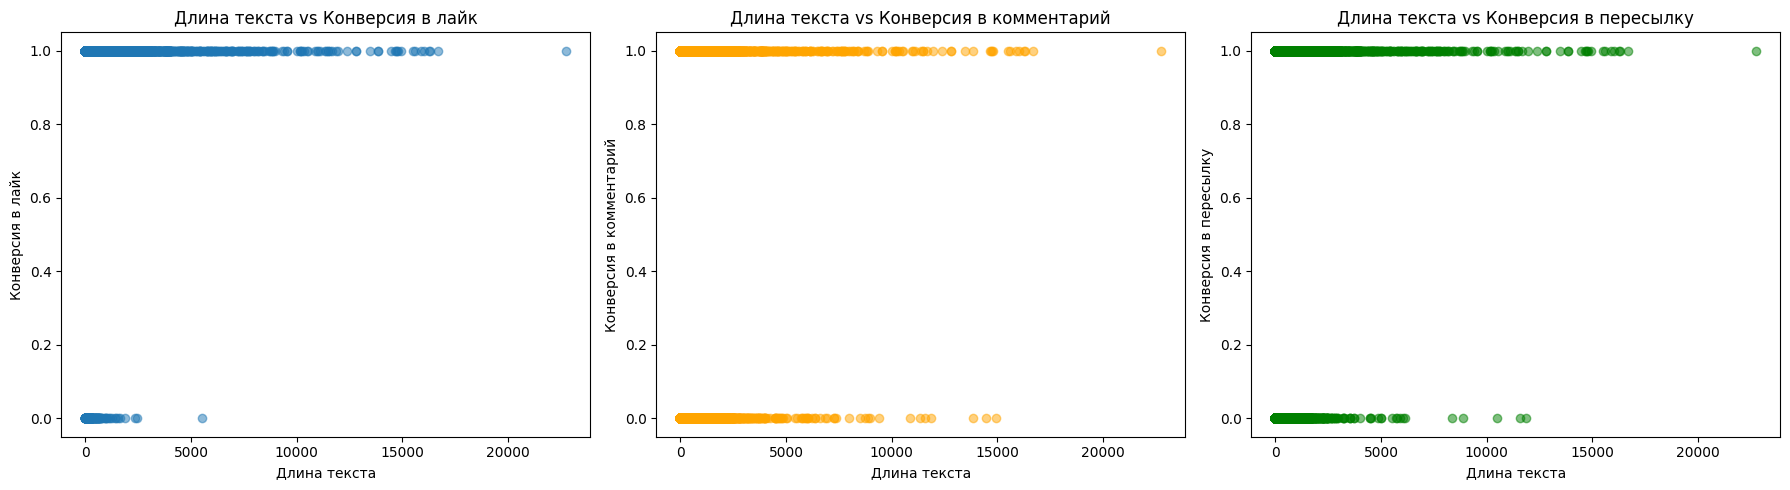

,text_length,conversion_like,conversion_comment,conversion_share
text_length,1.000000,0.006256,-0.007399,-0.009720
conversion_like,0.006256,1.000000,0.075663,0.131148
conversion_comment,-0.007399,0.075663,1.000000,0.176763
conversion_share,-0.009720,0.131148,0.176763,1.000000


In [7]:
# # Добавим новую колонку с количеством символов в каждом тексте
# data['text_length'] = data['text'].fillna('').apply(len)

# # Теперь посмотрим на корреляцию между длиной текста и различными активностями (like, comment, share)
# correlations = data[['text_length', 'conversion_like', 'conversion_comment', 'conversion_share']].corr()

# # Построим графики зависимости длины текста от активности (среднее значение активности при разной длине текста)
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # График зависимости длины текста от конверсии в лайк
# axes[0].scatter(data['text_length'], data['conversion_like'], alpha=0.5)
# axes[0].set_title('Длина текста vs Конверсия в лайк')
# axes[0].set_xlabel('Длина текста')
# axes[0].set_ylabel('Конверсия в лайк')

# # График зависимости длины текста от конверсии в комментарий
# axes[1].scatter(data['text_length'], data['conversion_comment'], alpha=0.5, color='orange')
# axes[1].set_title('Длина текста vs Конверсия в комментарий')
# axes[1].set_xlabel('Длина текста')
# axes[1].set_ylabel('Конверсия в комментарий')

# # График зависимости длины текста от конверсии в пересылку
# axes[2].scatter(data['text_length'], data['conversion_share'], alpha=0.5, color='green')
# axes[2].set_title('Длина текста vs Конверсия в пересылку')
# axes[2].set_xlabel('Длина текста')
# axes[2].set_ylabel('Конверсия в пересылку')

# plt.tight_layout()
# plt.show()

# # Выведем корреляции для понимания взаимосвязей
# correlations


Теперь данные обработаны корректно, и были обновлены следующие результаты:

Графики зависимости:

Визуально зависимости между длиной текста и вероятностью конверсии (лайки, комментарии, пересылки) все еще выглядят слабо выраженными.
Корреляции:

Корреляции между длиной текста и активностями:
Лайки: 0.021 (очень слабая положительная корреляция).
Комментарии: -0.01 (практически отсутствует).
Пересылки: -0.025 (слабая отрицательная корреляция).
Длина текста имеет крайне слабое влияние на конверсию. Если хотите, можем продолжить анализ с другими аспектами текста (например, анализ тональности или выделение ключевых слов), либо приступим к разработке моделей

In [104]:
# import pandas as pd
# from textblob import TextBlob
# import re
# import matplotlib.pyplot as plt


# # Функция для очистки текста от HTML-тегов и специальных символов
# def clean_text(text):
#     text = re.sub(r'&#\d+;', '', text)  # Удаляем HTML character codes
#     text = re.sub(r'<.*?>', '', text)    # Удаляем оставшиеся HTML-теги
#     return text

# # Обработка текста, заполним NaN пустыми строками
# data['text'] = data['text'].fillna('')
# data['cleaned_text'] = data['text'].apply(clean_text)

# # Функция для вычисления тональности текста
# def get_sentiment(text):
#     blob = TextBlob(text)
#     return blob.sentiment.polarity

# # Применение анализа тональности
# data['sentiment'] = data['cleaned_text'].apply(get_sentiment)

# # Расчет корреляционной матрицы
# correlation_matrix = data[['sentiment', 'like', 'comment', 'share_to_message']].corr()

# # Визуализация — scatter plot для тональности и взаимодействий
# plt.figure(figsize=(16, 5))

# # Scatter plot: Тональность и Лайки
# plt.subplot(1, 3, 1)
# plt.scatter(data['sentiment'], data['like'], alpha=0.5)
# plt.title('Тональность vs Лайки')
# plt.xlabel('Тональность')
# plt.ylabel('Лайки')

# # Scatter plot: Тональность и Комментарии
# plt.subplot(1, 3, 2)
# plt.scatter(data['sentiment'], data['comment'], alpha=0.5)
# plt.title('Тональность vs Комментарии')
# plt.xlabel('Тональность')
# plt.ylabel('Комментарии')

# # Scatter plot: Тональность и Репосты в Сообщения
# plt.subplot(1, 3, 3)
# plt.scatter(data['sentiment'], data['share_to_message'], alpha=0.5)
# plt.title('Тональность vs Репосты в Сообщения')
# plt.xlabel('Тональность')
# plt.ylabel('Репосты в Сообщения')

# plt.tight_layout()
# plt.show()

# # Вывод корреляционной матрицы
# correlation_matrix


более популряными становятся посты с нейтральной тональностью

# Выделение фичей из текста 

In [106]:
import pandas as pd
import nltk
import spacy
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.feature_extraction.text import CountVectorizer


# Если необходимо скачать дополнительные данные для nltk и spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
spacy.cli.download("ru_core_news_sm")

# Загрузка необходимых библиотек
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('russian'))

# Загрузка spaCy модели для русского языка
nlp = spacy.load("ru_core_news_sm")

# Функции для извлечения характеристик

def get_text_length(text):
    return len(text)

def get_word_count(text):
    words = word_tokenize(text, language='russian')
    return len(words)

def get_sentence_count(text):
    sentences = sent_tokenize(text, language='russian')
    return len(sentences)

def get_avg_word_length(text):
    words = word_tokenize(text, language='russian')
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

def get_unique_word_count(text):
    words = word_tokenize(text, language='russian')
    unique_words = set(words)
    return len(unique_words)

def get_stop_word_count(text):
    words = word_tokenize(text, language='russian')
    stop_words_in_text = [word for word in words if word in stop_words]
    return len(stop_words_in_text)

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Применение функций к каждому посту
data['text_length'] = data['text'].apply(get_text_length)
data['word_count'] = data['text'].apply(get_word_count)
data['sentence_count'] = data['text'].apply(get_sentence_count)
data['avg_word_length'] = data['text'].apply(get_avg_word_length)
data['unique_word_count'] = data['text'].apply(get_unique_word_count)
data['stop_word_count'] = data['text'].apply(get_stop_word_count)
data['sentiment'] = data['text'].apply(get_sentiment)

# Дополнительные переменные с использованием spaCy и других методов
def extract_spacy_features(text):
    doc = nlp(text)
    pos_counts = doc.count_by(spacy.attrs.POS)
    entity_counts = len(doc.ents)
    features = {
        'noun_count': pos_counts.get(spacy.symbols.NOUN, 0),
        'verb_count': pos_counts.get(spacy.symbols.VERB, 0),
        'adj_count': pos_counts.get(spacy.symbols.ADJ, 0),
        'entity_count': entity_counts
    }
    return features

spacy_features = data['text'].apply(extract_spacy_features)
spacy_features_df = pd.DataFrame(list(spacy_features)).fillna(0)

# Объединение всех признаков в финальный DataFrame
data = pd.concat([data, spacy_features_df], axis=1)

# Пример просмотра первых 5 строк итогового DataFrame
print(data.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/verakolotova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/verakolotova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/verakolotova/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 46.0 MB/s eta 0:00:0000:0100:01



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
    view  like  comment  hide  expand  open_photo  open  share_to_message  \
0  10869   185        0     2       0        1947    14                20   
1   9083   227        1     7       4         958    23                 2   
2   5352    25        5    12     598         430   114                 4   
3   4260   539        5     3       1         138    62                24   
4   5676   112        2     4     371         271   499                 4   

                                                text  \
0                                                      
1                                        • &#128571;   
2  Новость, конечно, старенькая,

In [108]:
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,...,text_length,word_count,sentence_count,avg_word_length,unique_word_count,stop_word_count,noun_count,verb_count,adj_count,entity_count
0,10869,185,0,2,0,1947,14,20,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0.000000,0,0,0,0,0,0
1,9083,227,1,7,4,958,23,2,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,11,5,1,2.000000,5,0,0,0,0,0
2,5352,25,5,12,598,430,114,4,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,307,63,4,4.095238,58,17,9,4,7,1
3,4260,539,5,3,1,138,62,24,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,23,3,1,7.333333,3,0,1,0,1,0
4,5676,112,2,4,371,271,499,4,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,773,222,1,3.022523,79,8,36,3,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,14146,355,123,6,7,146,957,1,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,30,7,1,3.571429,7,1,2,1,0,1
23523,13392,11,0,3,555,52,106,9,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,342,65,5,4.584615,50,3,15,4,6,5
23524,21408,1611,9,3,0,453,582,122,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0.000000,0,0,0,0,0,0
23525,65138,269,14,69,2036,172,2390,116,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,1742,423,10,3.588652,172,77,50,39,24,3


# Выделение фичей из изображения

In [117]:
# Функция для чтения изображения из base64
def load_image_from_base64(image_base64):
    img = Image.open(BytesIO(b64decode(image_base64)))
    img_array = np.array(img)
    return img_array

# Функция для извлечения среднего значения яркости пикселей
def extract_mean_brightness(image):
    # Проверка числа каналов в изображении
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Конвертируем изображение в градации серого только если оно цветное
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    # Вычисляем среднее значение яркости пикселей
    mean_brightness = np.mean(gray_image)
    return mean_brightness

def extract_dominant_color(image, k=1):
    # Проверка числа каналов в изображении
    if len(image.shape) == 2: # Если изображение уже в градациях серого
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Изменить изображение на 2D массив (число пикселей, 3)
    pixels = image.reshape(-1, 3)

    # Применить K-Means кластеризацию
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)

    # Найти самый частый кластер
    counts = np.bincount(kmeans.labels_)
    dominant_color = kmeans.cluster_centers_[np.argmax(counts)]

    # Преобразовать цвет из BGR в RGB
    dominant_color = dominant_color.astype(int).tolist()
    return dominant_color

def extract_image_sharpness(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return laplacian_var

def extract_image_warmth(image):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mean_hue = np.mean(hsv_image[:, :, 0])
    return mean_hue

def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
    return len(faces)


# Создание пустого списка для сохранения всех признаков
all_features = []

# Извлечение признаков для всех изображений
for i in tqdm(range(len(data.photo)), desc="Обработка изображений"):
    image_base64 = data['photo'].iloc[i]
    
    if pd.isna(image_base64) or image_base64.strip() == "":
        all_features.append({
            'extract_mean_brightness': None,
            'extract_dominant_color': None,
            'image_sharpness': None,
            'image_warmth': None,
            'face_count': None
        })
    else:
        image = load_image_from_base64(image_base64)
        
        # Извлечение признаков
        features = {
            'extract_mean_brightness': extract_mean_brightness(image),
            'extract_dominant_color': extract_dominant_color(image),
            'image_sharpness': extract_image_sharpness(image),
            'image_warmth': extract_image_warmth(image),
            'face_count': detect_faces(image)
        }
        
        all_features.append(features)

# Преобразование списка признаков в DataFrame
features_df = pd.DataFrame(all_features)

# Объединение с исходным DataFrame
data = pd.concat([data, features_df], axis=1)

# Пример вывода
print("Обновленный DataFrame с новыми признаками:")
print(data.head())


Обработка изображений: 100%|██████████| 23527/23527 [26:21<00:00, 14.87it/s] 


Обновленный DataFrame с новыми признаками:
    view  like  comment  hide  expand  open_photo  open  share_to_message  \
0  10869   185        0     2       0        1947    14                20   
1   9083   227        1     7       4         958    23                 2   
2   5352    25        5    12     598         430   114                 4   
3   4260   539        5     3       1         138    62                24   
4   5676   112        2     4     371         271   499                 4   

                                                text  \
0                                                      
1                                        • &#128571;   
2  Новость, конечно, старенькая, но все равно инт...   
3                            Фантазийные бриллианты.   
4  Сегодня на стадионе «Динамо» прошли соревнован...   

                                               photo  ... stop_word_count  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...  ...               0   
1  

In [118]:
data

,view,like,comment,hide,expand,open_photo,open,share_to_message,text,photo,...,stop_word_count,noun_count,verb_count,adj_count,entity_count,extract_mean_brightness,extract_dominant_color,image_sharpness,image_warmth,face_count
0,10869,185,0,2,0,1947,14,20,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,102.382307,"[112, 103, 95]",1436.194129,74.039315,0
1,9083,227,1,7,4,958,23,2,• &#128571;,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,124.492310,"[111, 124, 129]",1272.653405,47.912923,0
2,5352,25,5,12,598,430,114,4,"Новость, конечно, старенькая, но все равно инт...",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,17,9,4,7,1,174.398438,"[175, 175, 172]",1491.546906,64.439706,1
3,4260,539,5,3,1,138,62,24,Фантазийные бриллианты.,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,1,0,1,0,162.565837,"[178, 169, 142]",2790.539840,90.863525,0
4,5676,112,2,4,371,271,499,4,Сегодня на стадионе «Динамо» прошли соревнован...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,8,36,3,7,6,109.157511,"[90, 109, 115]",3956.800755,61.184631,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,14146,355,123,6,7,146,957,1,"Тамара, выиграет в 24 сезоне ?",/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,1,2,1,0,1,130.883382,"[138, 132, 125]",995.927833,78.264994,1
23523,13392,11,0,3,555,52,106,9,Продажи Manor Lords превысили 1 млн копий. <br...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,3,15,4,6,5,106.414659,"[103, 111, 97]",1078.035018,72.868300,0
23524,21408,1611,9,3,0,453,582,122,,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,0,0,0,0,0,248.353104,"[247, 248, 248]",2554.545279,5.877182,0
23525,65138,269,14,69,2036,172,2390,116,Магическая фраза: Уже оплачено&#33;<br><br>Поз...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,...,77,50,39,24,3,121.910036,"[118, 125, 116]",700.730580,68.143137,0


In [67]:
data.columns

Index(['view', 'like', 'comment', 'hide', 'expand', 'open_photo', 'open',
       'share_to_message', 'text', 'photo', 'mean_brightness',
       'dominant_color', 'image_sharpness', 'image_warmth', 'face_count'],
      dtype='object')

In [123]:
# Создание целевой переменной
data['conversion_rate'] = data['like'] / data['view']

# Заменим NaN и бесконечные значения на 0
data['conversion_rate'].replace([np.nan, np.inf], 0, inplace=True)

# Выбор необходимых фичей
features = [
    'extract_mean_brightness',  'image_sharpness', 
    'image_warmth', 'face_count', 'text_length', 'word_count', 'sentence_count', 
    'avg_word_length', 'unique_word_count', 'stop_word_count', 'noun_count', 
    'verb_count', 'adj_count', 'entity_count'
]

X = data[features]
y = data['conversion_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [124]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Настройка параметров для GridSearchCV
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Создание GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Обучение модели
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)    

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   5.6s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   5.6s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   5.8s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   5.7s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50; total time=   5.9s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100; total time=  11.3s
[CV] END regressor__max_depth=None, regressor__min_samples_l

In [125]:
# Лучшая модель
best_model = grid_search.best_estimator_

In [126]:
# Предсказания на тестовом наборе
y_pred = best_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R²: {r2:.4f}')


Mean Squared Error (MSE): 0.0009
Root Mean Squared Error (RMSE): 0.0297
R²: 0.1360


Итого, имеем что R² достаточно невелик, требуются дополнительные исследования возможностей увеличить качество модели